In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
fig_dir = "/home/mplitt/Fig_scratch/YMaze/behavior"
os.makedirs(fig_dir,exist_ok=True)
dt = 15.46

In [3]:
print(ko_mice)

('4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', 'Cre7', 'Cre9', 'CA3-1')


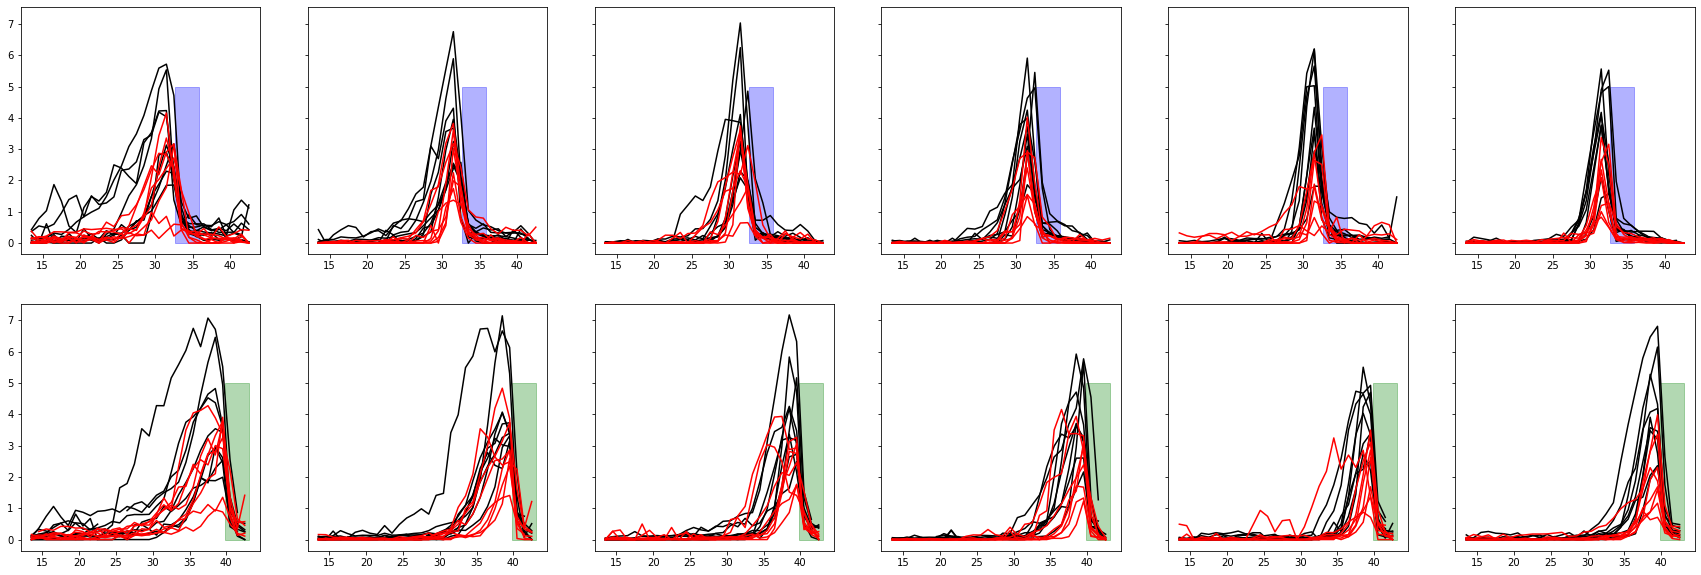

In [4]:
fig, ax = plt.subplots(2,6,figsize=[30,10], sharey=True)

ko_lr = {}
ctrl_lr = {}
for day in range(6):
    
    ctrl_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ctrl_mice):
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        
        ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:].mean(axis=0),color='black')
        ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='black')
        
        if i == 0:
            ax[1,day].fill_betweenx([0,5], sess.rzone_late['tfront'], sess.rzone_late['tback'],zorder=0, color='green',alpha=.3)
            ax[0,day].fill_betweenx([0,5],sess.rzone_early['tfront'], sess.rzone_early['tback'],zorder=0, color='blue',alpha=.3)
            
            t_bins = sess.trial_matrices['bin_edges'][1:]
            rzone_early = (t_bins>=sess.rzone_early['tfront']-3)*(t_bins<=sess.rzone_early['tfront'])
            rzone_late = (t_bins>=sess.rzone_late['tfront']-3)*(t_bins<=sess.rzone_late['tfront'])
            
        ctrl_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==-1,:][:,rzone_early]))
        ctrl_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        
    ko_lr[day]={'left':[],'right':[]}
    for i, mouse in enumerate(ko_mice):
        try:
            sess = u.load_vr_day(mouse,day, verbose=False)
            trial_mask = sess.trial_info['LR']==-1
            if day==0 and i == 3:
                trial_mask[35:66]=False

            ax[0,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][trial_mask,:].mean(axis=0),color='red')
            ax[1,day].plot(sess.trial_matrices['bin_centers'], dt*sess.trial_matrices['licks'][sess.trial_info['LR']==1,:].mean(axis=0),color='red')

            ko_lr[day]['left'].append(dt*np.nanmean(sess.trial_matrices['licks'][trial_mask,:][:,rzone_early]))
            ko_lr[day]['right'].append(dt*np.nanmean(sess.trial_matrices['licks'][sess.trial_info['LR']==1,:][:,rzone_late]))
        except:
            pass

left day 0: t:-1.250926, p:0.210962
right day 0: t:-1.347151, p:0.177932
left day 1: t:-2.309401, p:0.020921
right day 1: t:-2.309401, p:0.020921
left day 2: t:-1.058475, p:0.289839
right day 2: t:-1.828276, p:0.067508
left day 3: t:-2.598076, p:0.009375
right day 3: t:-2.116951, p:0.034264
left day 4: t:-2.886751, p:0.003892
right day 4: t:-2.886751, p:0.003892
left day 5: t:-2.598076, p:0.009375
right day 5: t:-2.886751, p:0.003892


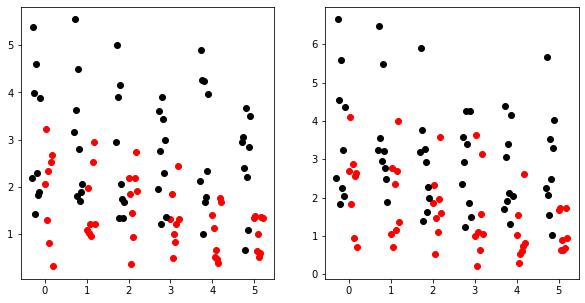

In [5]:
fig, ax = plt.subplots(1,2, figsize=[10,5])

for day in range(6):
    for ax_ind, lr in enumerate(('left', 'right')):
    
        ko = np.array(ko_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day,day+.2, num = ko.shape[0]),ko, color='red')

        ctrl = np.array(ctrl_lr[day][lr])
        ax[ax_ind].scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black')
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,ctrl)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))

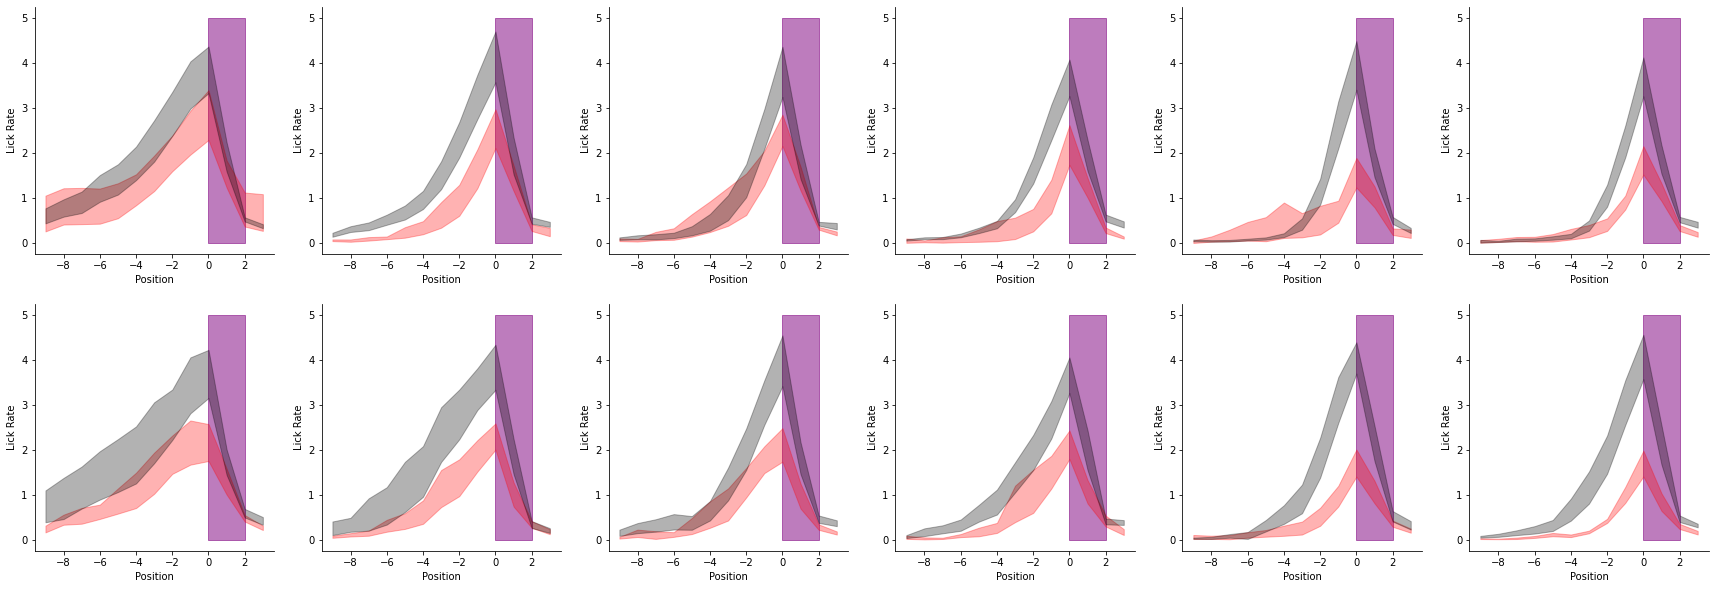

In [6]:
fig,ax = plt.subplots(2,6, figsize = [30, 10])


df = pd.DataFrame({'mouse':[],
                        'ko':[],
                        'day':[],
                        'day_norm': [],
                        'dz': [],
                        'ko_x_day': [],
                        'nov_lr':[], 
                        'fam_lr':[], 
                        })

ko_lr, ctrl_lr = {}, {}
for day in range(6):
    ko_lr[day] = {'fam':[],'nov':[]}
    
    x = np.arange(-10,3)
    for mouse in ko_mice:

        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            lick_mean = np.nanmean(sess.trial_matrices['licks'][trial_mask,:].ravel())

            mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:
                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
            if lr == sess.novel_arm:
                ko_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ko_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front+1])
            else:
                ko_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front+1])
#                 ko_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                
                    
                
        df = df.append({'mouse': mouse, 
                            'ko': 1, 
                            'day': day,
                            'day_norm': (day+1)/6.,
                            'ko_x_day': (day+1)/6.,
                            'nov_lr': _nov,
                            'fam_lr': _fam,
                                }, ignore_index=True)
                      

    ctrl_lr[day] = {'fam':[],'nov':[]}
    x = np.arange(-9,4)
    for mouse in ctrl_mice:
        sess = u.load_vr_day(mouse,day, trial_mat_keys = ('licks','nonconsum_licks','speed'),verbose = False)
        bin_edges = sess.trial_matrices['bin_edges']
        for ax_ind, lr in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']== lr
            lick_mean = np.nanmean(sess.trial_matrices['licks'][trial_mask,:].ravel())

            mu = dt*np.nanmean(sess.trial_matrices['nonconsum_licks'][trial_mask,:], axis=0)

            if sess.novel_arm ==-1:

                fam_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]

            elif sess.novel_arm == 1:
                fam_rzone_front = np.argwhere((sess.rzone_early['tfront']<=bin_edges[1:])*(sess.rzone_early['tfront']>=bin_edges[:-1]))[0][0]
                nov_rzone_front = np.argwhere((sess.rzone_late['tfront']<=bin_edges[1:])*(sess.rzone_late['tfront']>=bin_edges[:-1]))[0][0]

            if lr == sess.novel_arm:
                ctrl_lr[day]['nov'].append(mu[nov_rzone_front-10:nov_rzone_front+3])
#                 ctrl_mu[day]['nov'].append(np.nanmean(mu[nov_rzone_front-3:nov_rzone_front]))
                _nov = np.nanmean(mu[nov_rzone_front-3:nov_rzone_front])
            else:
                ctrl_lr[day]['fam'].append(mu[fam_rzone_front-10:fam_rzone_front+3])
#                 ctrl_mu[day]['fam'].append(np.nanmean(mu[fam_rzone_front-3:fam_rzone_front]))
                _fam = np.nanmean(mu[fam_rzone_front-3:fam_rzone_front])
                
            df = df.append({'mouse': mouse, 
                            'ko': 0, 
                            'day': day,
                            'day_norm': (day+1)/6.,
                            'ko_x_day': 0,
                            'nov_lr': _nov,
                            'fam_lr': _fam,
                                }, ignore_index=True)
        
    

for day in range(6):
    for ax_ind, lr in enumerate(['fam', 'nov']):
        arr = np.array(ko_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind,day].fill_between(x, mu- sem, mu+sem,color='red', alpha = .3)

        arr = np.array(ctrl_lr[day][lr])
        mu, sem = np.nanmean(arr,axis=0), sp.stats.sem(arr, axis=0, nan_policy='omit')
        ax[ax_ind, day].fill_between(x, mu- sem, mu+sem,color='black', alpha = .3)
    #     ax[ax_ind].plot(x, np.array(ko_mu[lr]).T,color='red', alpha = .3)


    
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)
        ax[ax_ind, day].fill_betweenx([0,5], 0, 2, zorder=-1, color='purple',alpha=.3)

        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_xlabel('Position')
        ax[ax_ind, day].set_ylabel('Lick Rate')
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['top'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)
        ax[ax_ind, day].spines['right'].set_visible(False)

fig.savefig(os.path.join(fig_dir, 'famnov_lickrate_alldays.pdf'))

fam_lr day 0: t:-1.027778, p:0.304054
nov_lr day 0: t:-1.666667, p:0.095581
fam_lr day 1: t:-2.694444, p:0.007051
nov_lr day 1: t:-2.888889, p:0.003866
fam_lr day 2: t:-1.416667, p:0.156580
nov_lr day 2: t:-2.777778, p:0.005473
fam_lr day 3: t:-2.972222, p:0.002957
nov_lr day 3: t:-2.888889, p:0.003866
fam_lr day 4: t:-2.861111, p:0.004222
nov_lr day 4: t:-4.000000, p:0.000063
fam_lr day 5: t:-2.416667, p:0.015663
nov_lr day 5: t:-3.444444, p:0.000572


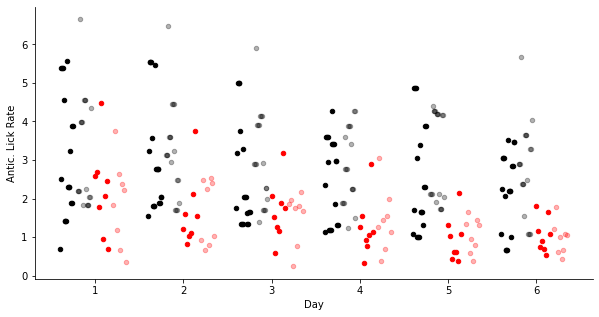

In [7]:
fig, ax = plt.subplots( figsize=[10,5], sharey=True)

for day in range(6):
    for i, lr in enumerate(('fam_lr', 'nov_lr')):
        
        ko = df[lr].loc[(df['ko']==1) & (df['day']==day)]._values
        if i == 0:
            ax.scatter(np.linspace(day,day+.15, num = ko.shape[0])+1,ko, color='red', s=20)
        else:
            ax.scatter(np.linspace(day+.2,day+.35, num = ko.shape[0])+1,ko, color='red', s=20, alpha=.3)

        ctrl = df[lr].loc[(df['ko']==0) & (df['day']==day)]._values
        if i == 0:
            ax.scatter(np.linspace(day-.4,day-.25, num = ctrl.shape[0])+1,ctrl, color='black', s=20)
        else:
            ax.scatter(np.linspace(day-.2,day-.05, num = ctrl.shape[0])+1,ctrl, color='black', s=20, alpha=.3)
#         ax.scatter(np.linspace(day-.3, day-.1, num = ctrl.shape[0]),ctrl, color='black', s=20)
    #     print(ko,ctrl)
        t,p = sp.stats.ranksums(ko,ctrl)
        print("%s day %d: t:%f, p:%f" % (lr, day,t,p))
        
        

ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Antic. Lick Rate')
ax.set_xlabel('Day')

fig.savefig(os.path.join(fig_dir, 'famnov_average_lickrate_summary.pdf'))

In [10]:
aov = mixed_anova(data=df, dv='fam_lr', between='ko', within='day', subject='mouse')
print(aov)

        Source         SS  DF1  DF2         MS         F     p-unc  p-GG-corr  \
0           ko  35.767633    1   15  35.767633  8.164595  0.011986        NaN   
1          day  11.988651    5   75   2.397730  5.304734  0.000316   0.002444   
2  Interaction   1.929710    5   75   0.385942  0.853857  0.516209        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.352460       NaN        NaN       NaN       NaN  
1  0.261256  0.629105      False  0.075722  0.001045  
2  0.053858       NaN        NaN       NaN       NaN  


In [11]:
aov = mixed_anova(data=df, dv='nov_lr', between='ko', within='day', subject='mouse')
print(aov)

        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0           ko  65.233199    1   15  65.233199  20.704831  0.000383  0.579889   
1          day   4.486182    5   75   0.897236   3.350163  0.008732  0.182569   
2  Interaction   1.661575    5   75   0.332315   1.240820  0.298671  0.076401   

       eps  
0      NaN  
1  0.76152  
2      NaN  


In [ ]:
lmm_res = MixedLM(cell_stats.df['avg_std'], cell_stats.df[['ko', 
                                                           'day', 
                                                           'novfam', 
                                                           'lr', 
                                                           'ko_x_day', 
                                                           'ko_x_novfam', 
                                                           'novfam_x_day',
                                                           'speed',
                                                           'intercept']], cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


In [4]:
sess = u.load_vr_day(ko_mice[7], 5)

{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1})
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 7}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10, 'novel_arm': -1, 'ravel_ind': 8})


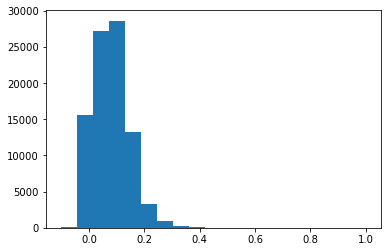

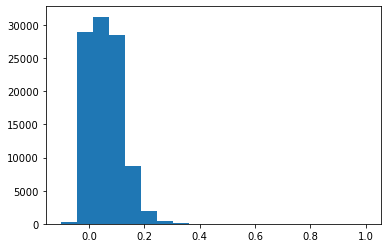

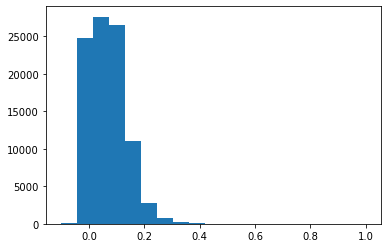

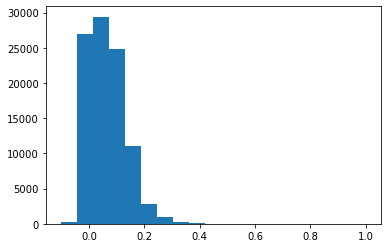

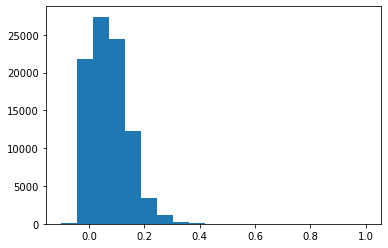

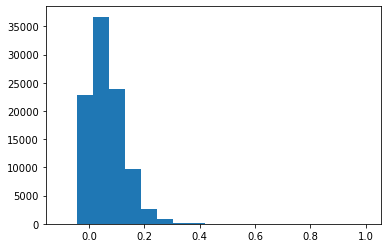

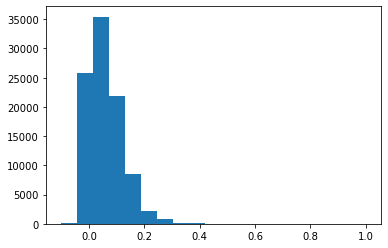

In [13]:
for i in range(7):
    sess = u.load_vr_day(ko_mice[0],i)
    fig,ax = plt.subplots()
    ax.hist(sess.timeseries['speed'].ravel(), bins = np.linspace(-.1,1, num=20))

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:8: RuntimeWarning: Mean of empty slice.
  ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:10: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: inval

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1})
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invali

{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': -1, 'novel_arm': -1, 'ravel_ind': 0}


<ipython-input-14-b3dc6793d03c>:18: RuntimeWarning: Mean of empty slice.
  ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-14-b3dc6793d03c>:20: RuntimeWarning: Mean of empty slice.
  ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 0.25)

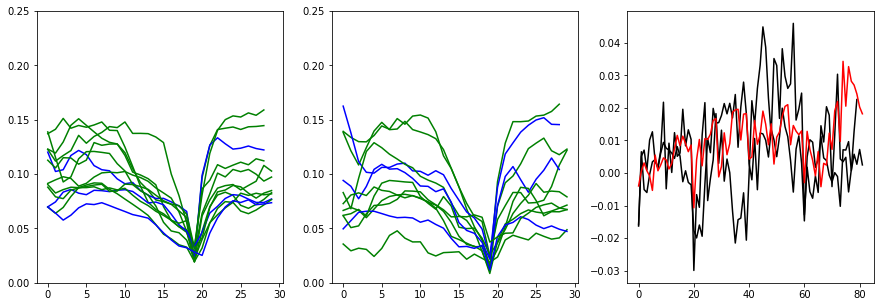

In [14]:
fig,ax = plt.subplots(1,3, figsize=[15,5])

for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[0].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[0].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'black' )

    
for mouse in ko_mice:
    sess = u.load_vr_day(mouse,0)
    left_post = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']>=2)
    ax[1].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=0), color= 'green')
    left_pre = (sess.trial_info['LR']==-1) & (sess.trial_info['block_number']<2)
    ax[1].plot(sess.trial_matrices['speed'][left_pre,:].mean(axis=0), color='blue')
    
    ax[2].plot(sess.trial_matrices['speed'][left_post,:].mean(axis=1) - sess.trial_matrices['speed'][left_pre,:].mean(), color = 'red' )
    
ax[0].set_ylim([0,.25])
ax[1].set_ylim([0,.25])
    

{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


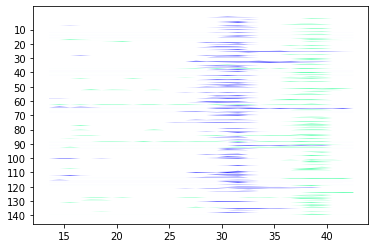

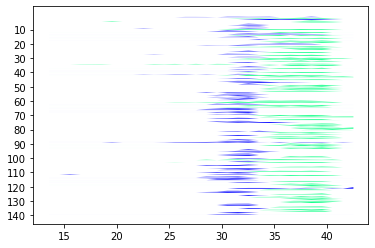

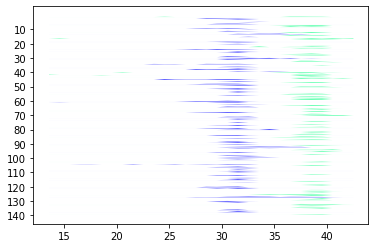

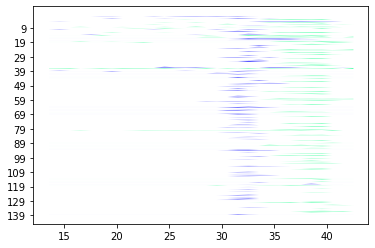

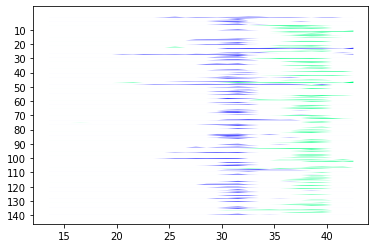

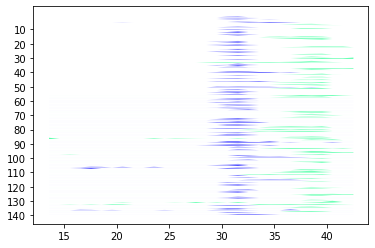

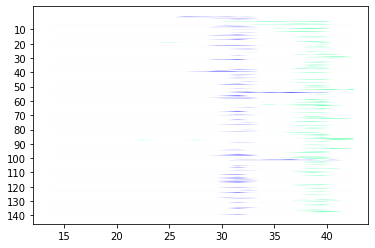

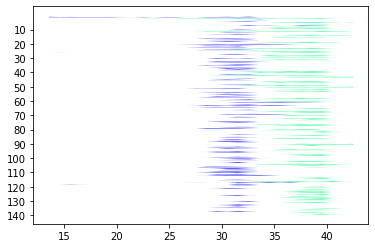

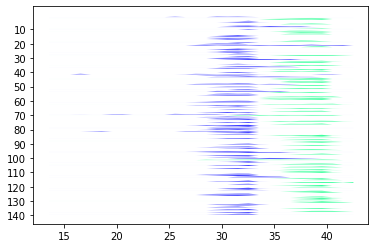

In [18]:
for mouse in ctrl_mice:
    sess = u.load_vr_day(mouse,5)
    
#     fig,ax = plt.subplots()
    fig, ax = tpu.utilities.smooth_raster(sess.trial_matrices['bin_centers'],sess.trial_matrices['licks'],vals = sess.trial_info['LR'],cmap='winter')
    